# Keras + Tensorflow MNIST

## Introduction

In this notebook, we implement a Convolutional Neural Network (CNN) model with Keras using the TensorFlow backend. We use the dataset from the Digit Recognizer competition of Kaggle (see [here](https://www.kaggle.com/c/digit-recognizer)).

We will use a VGG-like architecture for our neural network, this is, it will consist of a series of convolutional, followed by fully connected layers. We will also add pooling and dropout layers to decrease the number of parameters and to regularize the model.

## Getting started

We start by importing the necessary modules:

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from scipy.misc import toimage

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


We import the dataset into pandas dataframes

In [2]:
df_train = pd.read_csv("train.csv", encoding = 'ISO-8859-1')
df_subm =  pd.read_csv("test.csv", encoding = 'ISO-8859-1')

We check that there is no missing data:

In [3]:
df_train.isnull().sum().sum() , df_subm.isnull().sum().sum()

(0, 0)

There is in fact, no missing data. We now take a look at the dataframes to see their structure:

In [4]:
df_train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
df_subm.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We can see that the training data consists of 785 columns, from which the first one corresponds to the label of the digit, and the other 784 correspond to all the 28x28 pixels composing each image. The submission dataframe does not contain the label, as expected. We proceed to extract the labels from the dataframe.

In [6]:
X_train = df_train[df_train.columns[1:]]
y_train = df_train['label']

We now use the train_test_split tool from sklearn to separate our training data into two batches: one that we will use to train our neural network, and one that we will use to evaluate the scores.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train)

Now we use the to_categorical tool from Keras to one-hot-encode the labels of our dataset. This is, for each possible value of the labels, we create a column, and the column corresponding to the label has a 1, while the others have a 0.

In [8]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

Now that the dataset has the appropriate format, we can have a look at how the images look like:

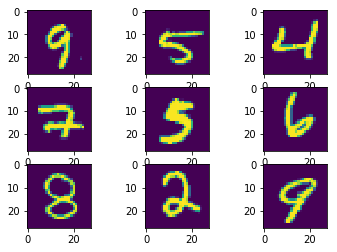

In [9]:
for i in range(0, 9):
    plt.subplot(330 + 1 + i)
    plt.imshow((X_train.iloc[i].values.reshape(28,28)))
plt.show()

Now we convert the dataframe into a 4 dimensional tensor. The first dimension runs through the set of examples, the second and third correspond to the two dimensions of the image and the fourth dimension correspond to the each channel of the picture (for RGB images we need three channels while for grayscale we only need one channel).

In [10]:
X_train = X_train.values.reshape(X_train.shape[0],28,28,1)
X_test = X_test.values.reshape(X_test.shape[0],28,28,1)
# X_train = X_train.values.reshape(df_train.shape[0],28,28)

We compute now the range of values that the data takes, so we can properly normalize:

In [11]:
X_train.max() - X_train.min() 

255

Now we can normalize:

In [12]:
X_train = X_train/255
X_test = X_test/255

We are now ready to build our model.

## CNN: the sequential model

Keras makes the construction of deep neural networks much easier than Tensorflow. For this, we just need to build a sequential model, and add each layer sequentially (as the name suggests), keeping in mind that the dimensions of the output of each layer must coincide with the dimensions of the input of the next layer. 

The architecture of the CNN is based on the VGG-like convolutional neural network provided by the Keras documentation (see [here](https://keras.io/getting-started/sequential-model-guide/#examples)).

We start by building the sequential model.

In [13]:
model = Sequential()

Now we add two groups of layers consisting of convolutions, maxpooling and dropout layers:

In [14]:
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

We follow this by two fully connected (dense) layers, with another dropout layer.

In [15]:
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

This finishes the architecture of the CNN. Now we choose an optimizer to train the model. We choose Stochastic Gradient Descent (SGD) with decay, momentum and Nesterov momentum for this.

In [16]:
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

Finally, we compile the model. We will use the categorical cross entropy as a loss function, and we will measure scores with the accuracy.

In [17]:
model.compile(loss='categorical_crossentropy', optimizer=sgd,metrics=['accuracy'])

We print a summary of the model.

In [18]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 64)          0         
__________

We are ready to train the model. We have commented this line as we will use a slightly modified version of this.

In [19]:
# model.fit(X_train, y_train, batch_size=128, epochs=10)

We can compute the score of the model on the test dataset:

In [20]:
# score = model.evaluate(X_test, y_test, batch_size=128)

With this model, we can obtain scores of around 0.988 on the submission data. We can improve this to get even higher scores.

## Data augmentation

In this section, we perform what is called Data Augmentation. This procedure consists of generating more data with our available dataset. The way we do this is by applying several transformations to our dataset. This is a widely used technique. For this, we will use the ImageDataGenerator tool from Keras.

We start by building the object that will randomly generate such transformations:

In [21]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    )

Here the parameters indicate that the pictures will be rotated in a random angle between -10,10 degrees, and a vertical and horizontal shift will be applied. In this way, we will count with a much more diverse dataset which will allow our model to learn better parameters for predicting in test datasets. We now fit the data generator to our training dataset.

In [22]:
datagen.fit(X_train)

Finally, we generate the data and fit the model with the augmented data:

In [23]:
model.fit_generator(datagen.flow(X_train, y_train, batch_size=128),
                    steps_per_epoch=int(len(X_train) / 128), epochs=30)

Epoch 1/30
246/246 [==============================] - 58s 235ms/step - loss: 1.2945 - acc: 0.5500
Epoch 2/30
246/246 [==============================] - 50s 203ms/step - loss: 0.3915 - acc: 0.8752
Epoch 3/30
246/246 [==============================] - 49s 198ms/step - loss: 0.2606 - acc: 0.9193
Epoch 4/30
246/246 [==============================] - 51s 208ms/step - loss: 0.2080 - acc: 0.9364
Epoch 5/30
246/246 [==============================] - 51s 206ms/step - loss: 0.1811 - acc: 0.9434
Epoch 6/30
246/246 [==============================] - 50s 205ms/step - loss: 0.1535 - acc: 0.9524
Epoch 7/30
246/246 [==============================] - 49s 199ms/step - loss: 0.1361 - acc: 0.9588
Epoch 8/30
246/246 [==============================] - 49s 201ms/step - loss: 0.1309 - acc: 0.9604
Epoch 9/30
246/246 [==============================] - 50s 203ms/step - loss: 0.1212 - acc: 0.9627
Epoch 10/30
246/246 [==============================] - 50s 202ms/step - loss: 0.1149 - acc: 0.9647
Epoch 11/30
246/246

And now we evaluate the model on the test data:

In [33]:
model.evaluate(X_test, y_test, batch_size=128)

10500/10500 [==============================] - 5s 520us/step


[0.019060105884366966, 0.9941904761904762]

We can check how is the model performing with the confusion matrix tool of Sklearn. This will show which numbers are being mislabeled.

In [34]:
confusion_matrix(np.argmax(y_test,axis=1,out=None),np.argmax(model.predict(X_test), axis=1, out=None))

array([[1062,    0,    1,    0,    1,    0,    1,    0,    0,    0],
       [   0, 1225,    2,    0,    0,    0,    0,    1,    0,    0],
       [   0,    1, 1002,    3,    0,    0,    0,    1,    2,    0],
       [   0,    0,    1, 1044,    0,    3,    0,    1,    2,    1],
       [   0,    1,    0,    0, 1002,    0,    0,    0,    0,    4],
       [   0,    0,    0,    2,    0,  965,    2,    0,    1,    0],
       [   0,    0,    0,    0,    0,    1,  992,    0,    0,    0],
       [   0,    1,    4,    0,    1,    0,    0, 1107,    0,    4],
       [   1,    0,    0,    0,    1,    2,    1,    1,  988,    3],
       [   1,    0,    0,    0,    6,    0,    0,    0,    3, 1052]],
      dtype=int64)

We can observe that the major source of errors are 4's being labeled as 9 and vice versa. This is mostly due to how some people draw these numbers in a very similar way. Finally, we can measure the accuracy of the model with the Sklearn accuracy tool:

In [35]:
accuracy_score(np.argmax(y_test,axis=1,out=None),np.argmax(model.predict(X_test), axis=1, out=None))

0.9941904761904762

## Submission 

Now we can proceed to generate the submission data. For this, we will use the same formatting as we used in the first part of the kernel. 

In [27]:
#We put the values of the submission data in a matrix
test_data = df_subm.values

In [28]:
#We reshape the matrix as a 4 dimensional tensor
test_data = test_data.reshape(test_data.shape[0],28,28,1)

In [29]:
#We normalize the data with the same factor as we did for the train data
test_data = test_data/255

In [30]:
#We use the model to generate the predictions
predictions = model.predict(test_data)

In [31]:
#We get the labels of the predictions, recalling that we used a one-hot-encoding 
#to train the model
predictions = np.argmax(predictions, axis=1, out=None)

In [32]:
#We generate a csv file with the predictions in the required format
with open("resultCNNwithPrepros.csv", "wb") as f:
    f.write(b'ImageId,Label\n')
    np.savetxt(f, np.hstack([(np.array(range(28000))+1).reshape(-1,1), predictions.astype(int).reshape(-1,1)]), fmt='%i', delimiter=",")

## Conclusion

This concludes this kernel. We believe that there is still room for improvement, either by optimizing over the architecture of the model or the hyperparameters.